In [14]:
%load_ext autoreload
%autoreload 2

from importers import SpikeImporter

data_folder = "../data/"
file_name = "20_05_13_U1a_complete"
file_ending = ".csv"

time_channel = "Time"
signal_channel = "1 Signal"
stimulus_channel = "32 DigMark"
ap_marker_channels = ["3 nw-1"]
extra_stimuli_channel = "801 DigMark"

# load the animal file
importer = SpikeImporter(filepath = data_folder + file_name + file_ending, time_channel = time_channel, signal_channel = signal_channel)

print("Data loaded.")

# define the max. time so that two sequential waveform-values are belonging to the same AP
# the time is in seconds, so 0.005 equals 5ms
max_gap_time = 0.005

# retrieve the events from the importer 
el_stimuli = importer.get_electrical_stimuli(regular_stimulus_channel = stimulus_channel)
el_extra_stimuli = importer.get_extra_stimuli(extra_stimulus_channel = extra_stimuli_channel, regular_el_stimuli = el_stimuli, verbose = False)
actpots = importer.get_action_potentials(ap_marker_channels = ap_marker_channels, verbose = False)
raw_signal = importer.get_raw_signal_split_by_stimuli(el_stimuli = el_stimuli, verbose = False)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Data loaded.
List of eletrical stimuli created.
List of extra eletrical stimuli created.
Finished processing AP channel 1 out of 1
List of APs created.
Done with cropping the intervals


In [15]:
'''
Here, we extract some features from the APs:
- postpulse distance (aka latency)
- normalized signal energy
'''
%autoreload 2
from tqdm import tqdm
from feature_extraction import calc_dist_to_prev_reg_el_stimulus, calc_normalized_energy

print("Extracting features from every AP")

# all_el_stimuli = el_stimuli.copy()
# all_el_stimuli.extend(importer.get_electrical_stimuli(regular_stimulus_channel = extra_stimuli_channel))

for ap in tqdm(actpots):
    ap.features["latency"], ap.prev_stimuli["regular"] = calc_dist_to_prev_reg_el_stimulus(ap, el_stimuli)
    ap.features["energy"] = calc_normalized_energy(ap)

 50%|█████████████████████████████████████▏                                     | 1255/2535 [00:00<00:00, 12427.55it/s]

Extracting features from every AP


100%|████████████████████████████████████████████████████████████████████████████| 2535/2535 [00:00<00:00, 5924.77it/s]


In [21]:
''' 
This cell performs the clustering according to
- distance to previous stimulus
- normalized signal energy of the APs
'''
%autoreload 2
from fibre_tracking import DBSCANClustering
from plotting import ClusterPlot2D

clustered_data_df = DBSCANClustering.perform_clustering(actpots, eps = 0.002, min_samples = 10, save_fibre_prediction = True)

cl2dplot = ClusterPlot2D()
cl2dplot.plot(clustered_data_df = clustered_data_df)

In [17]:
%autoreload 2
from plotting import FallingLeafPlot
from ipywidgets import interact_manual, interactive, fixed, IntSlider, FloatSlider

tmin, tmax = importer.get_time_range()
max_interval_length = max([stim.interval_length for stim in el_stimuli])

flplot = FallingLeafPlot()
interact_manual(flplot.plot, regular_stimuli = fixed(el_stimuli), action_potentials = fixed(actpots), \
                t_start = FloatSlider(min = tmin, max = tmax, value = 0), \
                num_intervals = IntSlider(min = 1, max = len(el_stimuli), step = 1, value = 5), \
                post_stimulus_timeframe = FloatSlider(min = 0, max = max_interval_length, value = 0.1), \
                manual_name = "Update Plot")

interactive(children=(FloatSlider(value=0.0, description='t_start', max=10630.1057), IntSlider(value=5, descri…

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>(*args, **kwargs)>

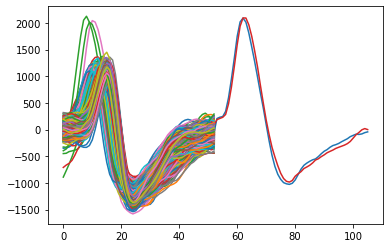

avg. len: 54 avg argmax: 15


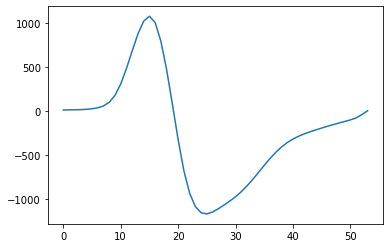

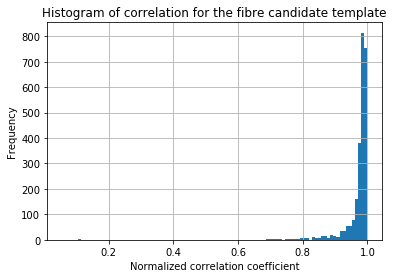

In [22]:
%autoreload 2
from fibre_tracking import ActionPotentialTemplate
from metrics import normalized_cross_correlation
import numpy as np
import matplotlib.pyplot as plt

# get the APs for a certain cluster number
cluster_idcs = [0]
filtered_aps = list(filter(lambda ap: ap.implied_fibre_index in cluster_idcs, actpots))

template_candidate = ActionPotentialTemplate.from_ap_list(aps = filtered_aps)
    
template = template_candidate.signal_template
corr = np.array([normalized_cross_correlation(template, ap.raw_signal) for ap in actpots])

plt.figure()
plt.hist(x = corr, bins = 100)
plt.grid(axis = 'both')
plt.xlabel("Normalized correlation coefficient")
plt.ylabel("Frequency")
plt.title("Histogram of correlation for the fibre candidate template")
plt.show()

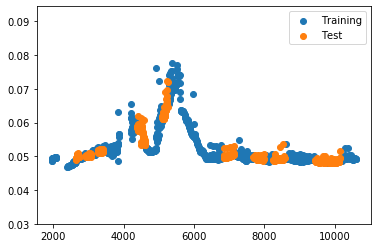

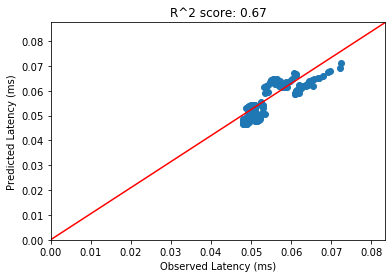

899
390


In [87]:
'''
    Try to perform some linear regression using the spike counts
'''
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from feature_extraction import get_adaptive_spike_count
from machine_learning import timebased_train_test_split
import matplotlib.pyplot as plt

for ap in actpots:
    ap.features["spikecount"] = get_adaptive_spike_count(actpot = ap, actpots = actpots, timeframe = 1600, num_splits = 16)
#    ap.features["spikecount"] = get_spike_count(actpot = ap, actpots = actpots, timeframe = 800, num_intervals = 16)
    
# restrict to only the "interesting" APs that we suspect as candidates
candidate_aps = [ap for ap in actpots if ap.implied_fibre_index == 0]

# get the features as lists
spike_counts = [ap.features["spikecount"] for ap in candidate_aps]
latencies = [ap.features["latency"] for ap in candidate_aps]

# perform a split on the set to get some data for training and some for evaluation
train_aps, test_aps = timebased_train_test_split(candidate_aps, test_percentage = 0.3, num_test_intervals = 10)

cnts_train = [ap.features["spikecount"] for ap in train_aps]
lat_train = [ap.features["latency"] for ap in train_aps]
cnts_test = [ap.features["spikecount"] for ap in test_aps]
lat_test = [ap.features["latency"] for ap in test_aps]

# plot the segments that have been selected for training and testing
plt.figure()
plt.scatter([ap.onset for ap in train_aps], [ap.features["latency"] for ap in train_aps], label = "Training")
plt.scatter([ap.onset for ap in test_aps], [ap.features["latency"] for ap in test_aps], label = "Test")
plt.legend()
plt.show()

# we should not use this sklearn function because it samples random data points from anywhere in the recording
# cnts_train, cnts_test, lat_train, lat_test = train_test_split(spike_counts, latencies, test_size = 0.2)

regression = LinearRegression().fit(X = cnts_train, y = lat_train)

lat_pred = regression.predict(cnts_test)

plt.figure()
plt.scatter(lat_test, lat_pred)
plt.gca().plot([0, 1], [0, 1], transform = plt.gca().transAxes, color = "r")
plt.xlabel("Observed Latency (ms)")
plt.ylabel("Predicted Latency (ms)")
plt.title("R^2 score: " + "{:.2f}".format(r2_score(lat_test, lat_pred)))
plt.gca().set_ylim(ymin=0)
plt.gca().set_xlim(xmin=0)
plt.show()

print(len(cnts_train))
print(len(cnts_test))

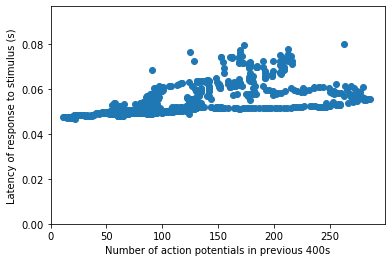

In [20]:
# restrict to only the "interesting" APs that we suspect as candidates
candidate_aps = [ap for ap in actpots if ap.implied_fibre_index == 0]

timeframe_len = 400

spike_counts = [get_spike_count(actpot = ap, actpots = actpots, timeframe = timeframe_len, num_intervals = 1) for ap in candidate_aps]
latencies = [ap.features["latency"] for ap in candidate_aps]

plt.figure()
plt.scatter(spike_counts, latencies)
plt.xlabel("Number of action potentials in previous " + str(timeframe_len) + "s")
plt.ylabel("Latency of response to stimulus (s)")
plt.gca().set_ylim(ymin=0)
plt.gca().set_xlim(xmin=0)
plt.show()